In [1]:
!nvidia-smi

Mon Feb  5 10:08:31 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.99       Driver Version: 527.99       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8    16W / 140W |   1322MiB /  8192MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
from PIL import Image
from typing import List
from tqdm import tqdm
import random
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import evaluate

c:\Users\jsilv\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
def display_image(img: torch.Tensor):
    if len(img.shape) != 3:
        img = img.numpy()
    else:
        img = img.numpy().transpose([1, 2, 0])

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)

In [4]:
sp_images = Path("archive/tampCOCO/sp_images/")
sp_masks = Path("archive/tampCOCO/sp_masks/")

In [5]:
cm_images = Path("archive/tampCOCO/cm_images/")
cm_masks = Path("archive/tampCOCO/cm_masks/")

In [6]:
np.unique([p.suffix for p in sp_images.glob("*")])

array(['.jpg'], dtype='<U4')

In [7]:
np.unique([p.suffix for p in cm_images.glob("*")])

array(['.jpg'], dtype='<U4')

In [8]:
np.unique([p.suffix for p in sp_masks.glob("*")])

array(['.png'], dtype='<U4')

In [9]:
np.unique([p.suffix for p in cm_masks.glob("*")])

array(['.png'], dtype='<U4')

In [10]:
sp_images_count = len(list(p for p in sp_images.glob("*.jpg")))
sp_images_count

199999

In [15]:
sp_masks_count = len(list(p for p in sp_masks.glob("*.png")))
sp_masks_count

199999

In [11]:
cm_images_count = len(list(p for p in cm_images.glob("*.jpg")))
cm_images_count

199429

In [12]:
cm_masks_count = len(list(p for p in cm_masks.glob("*.png")))
cm_masks_count

199429

In [16]:
i = 0
for image_p, mask_p in zip(
    cm_images.glob("*.jpg"),
    cm_masks.glob("*.png"),
):
    image = cv2.imread(str(image_p))
    mask = cv2.imread(str(mask_p))
    print(image.shape)
    print(mask.shape)
    break

(640, 512, 3)
(640, 512, 3)


In [17]:
class SemanticSegmentationDataset(Dataset):

    def __init__(
            self, 
            images_path: Path,
            masks_path: Path,
            image_processor: SegformerImageProcessor, 
    ):
        self.images_path = images_path
        self.masks_path = masks_path
        self.images = list(p for p in images_path.glob("*.jpg"))
        self.masks = list(p for p in masks_path.glob("*.png"))
        self.image_processor = image_processor

        assert len(self.images) == len(self.masks)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx: int):
        image_path = self.images[idx]
        image = cv2.imread(str(image_path))

        mask_path = (
            self.masks_path
            / image_path.name.replace(".jpg", ".png")
        )
        mask = (cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE) / 255).astype(np.int16)    

        # randomly crop and pad both image and segmentation map the same size
        encoded_inputs = self.image_processor(image, mask, return_tensors="pt")

        for k in encoded_inputs.keys():
            encoded_inputs[k].squeeze_() # remove batch dimension
        
        return encoded_inputs


In [18]:
image_processor = SegformerImageProcessor(
    do_resize=True,
    size={"height": 512, "width": 512},
    do_rescale=True,
    rescale_factor=1/255,
    do_normalize=True,
    reduce_labels=False,
)

c:\Users\jsilv\anaconda3\envs\pytorch\Lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [19]:
for path in sp_images.glob("*.jpg"):
    break

In [20]:
path

WindowsPath('archive/tampCOCO/sp_images/100_000000000077.jpg_000000220218.jpg_RS0.95.jpg')

In [21]:
ds = SemanticSegmentationDataset(
    sp_images,
    sp_masks,
    image_processor,
)

In [22]:
len(ds)

199999

In [23]:
train_lenght = int(len(ds)*0.95)
train_ds, validation_ds = torch.utils.data.random_split(ds, [train_lenght, len(ds) - train_lenght])

In [24]:
len(train_ds), len(validation_ds)

(189999, 10000)

In [25]:
train_ds[0].keys()

dict_keys(['pixel_values', 'labels'])

In [26]:
train_ds[0]["pixel_values"].shape, train_ds[0]["labels"].shape

(torch.Size([3, 512, 512]), torch.Size([512, 512]))

In [27]:
train_ds[0]["labels"].unique()

tensor([0, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


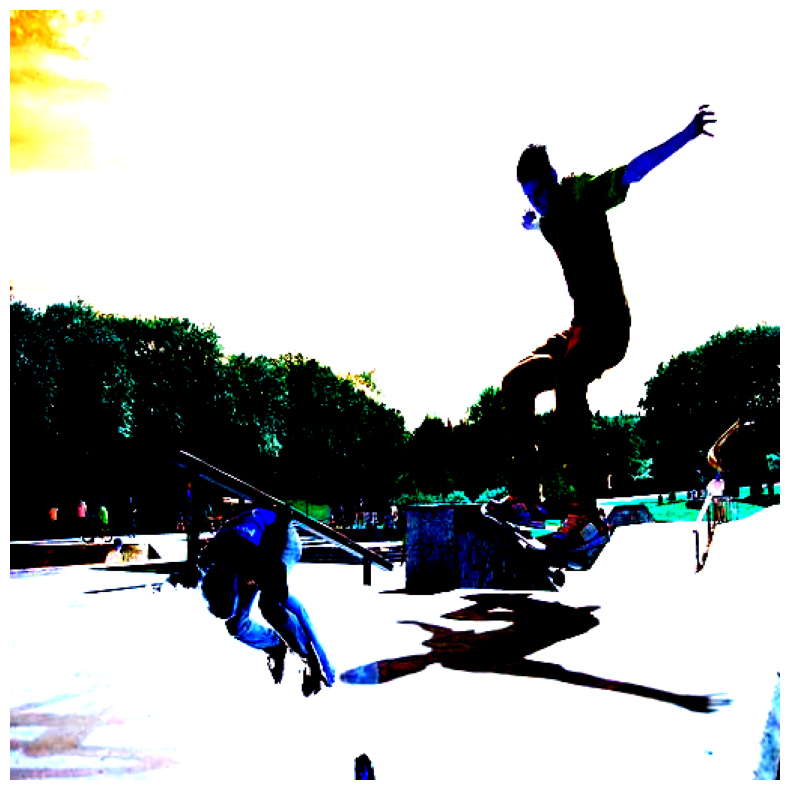

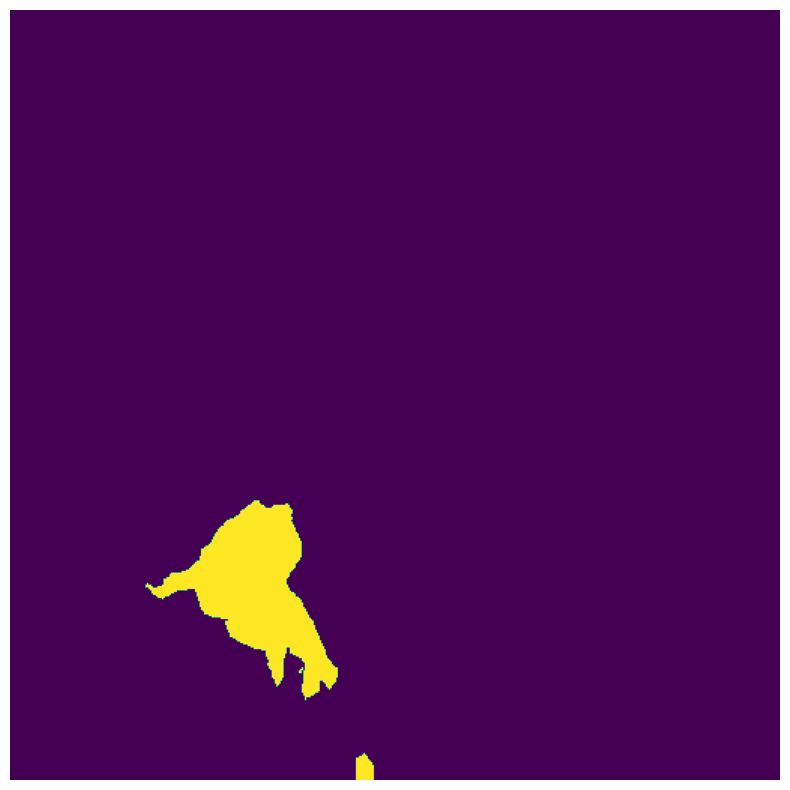

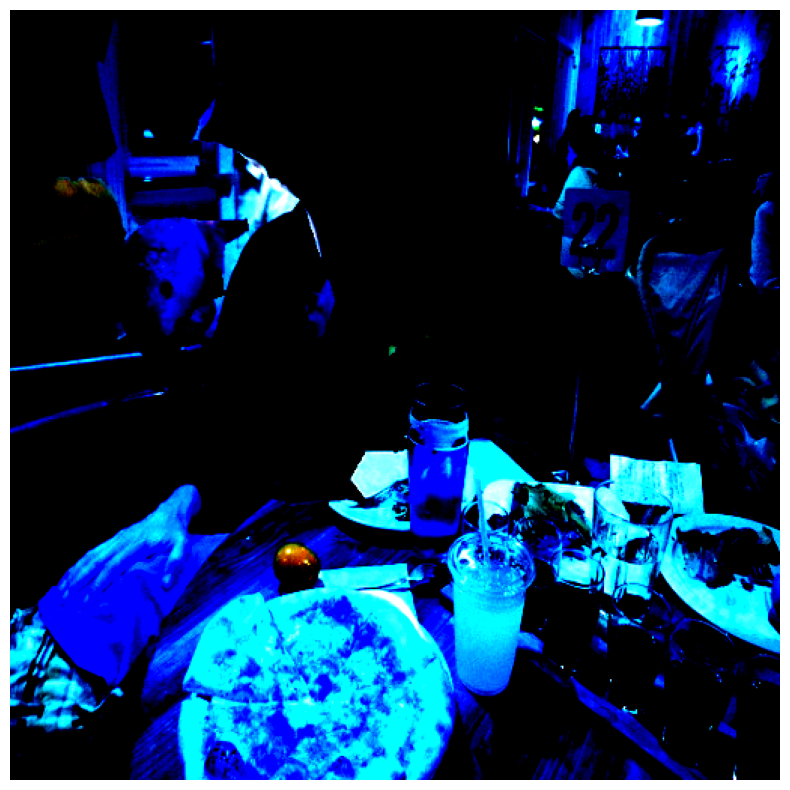

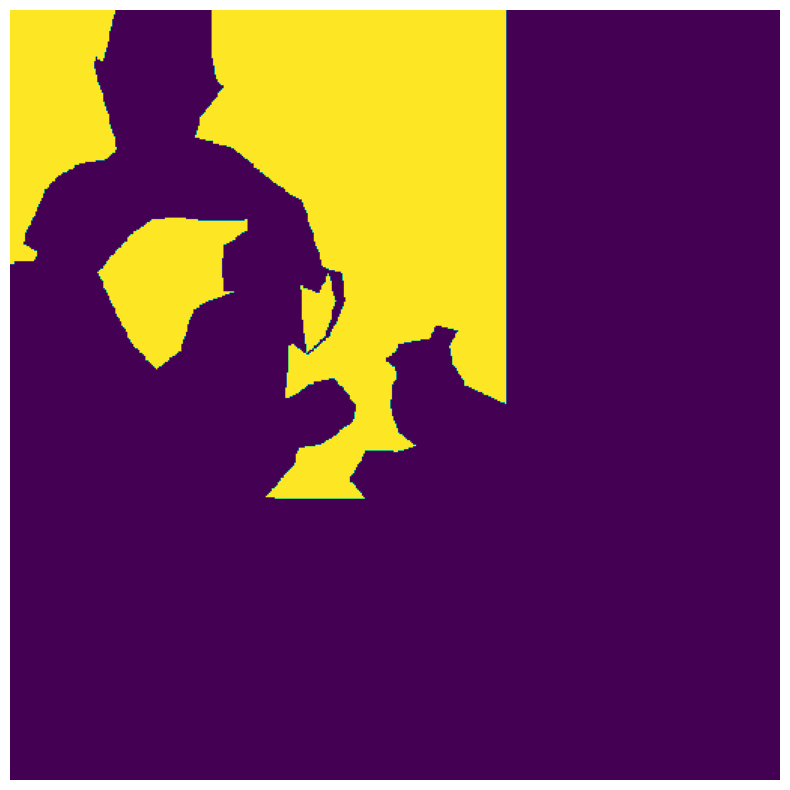

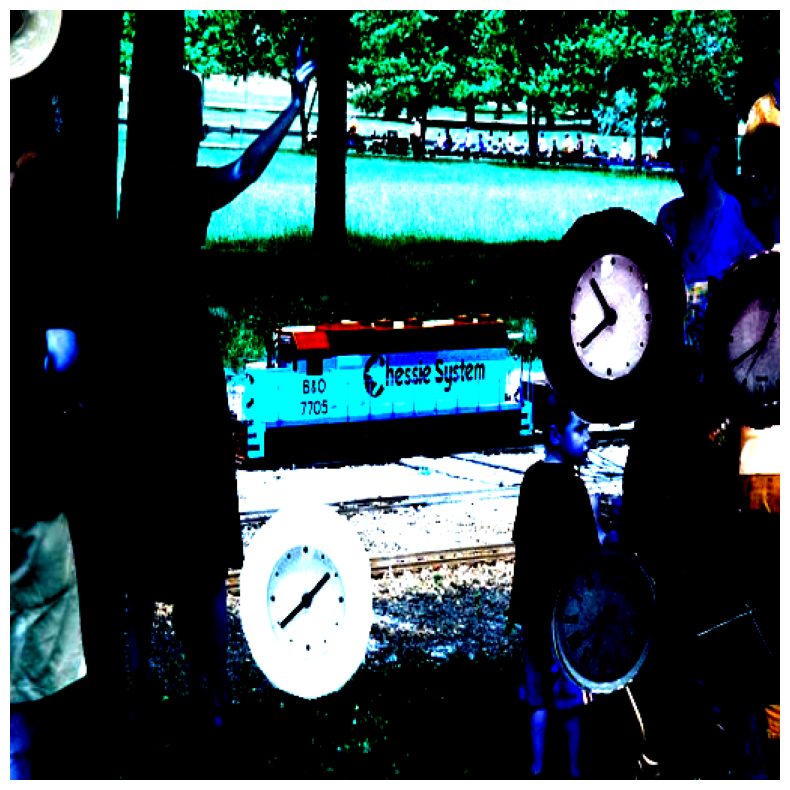

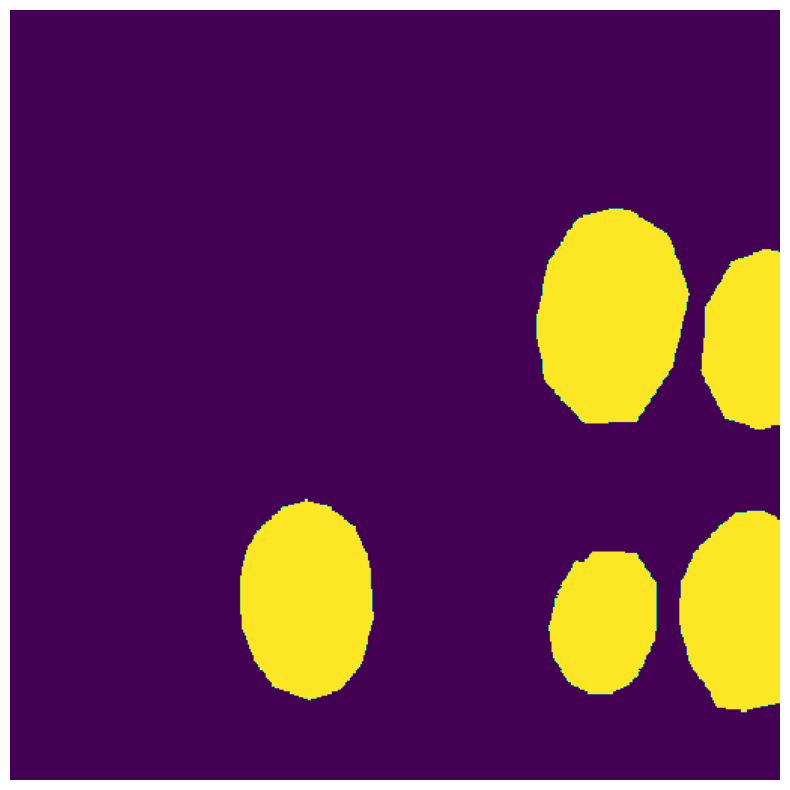

In [28]:
for i in range(3):
    display_image(train_ds[i]["pixel_values"])
    display_image(train_ds[i]["labels"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


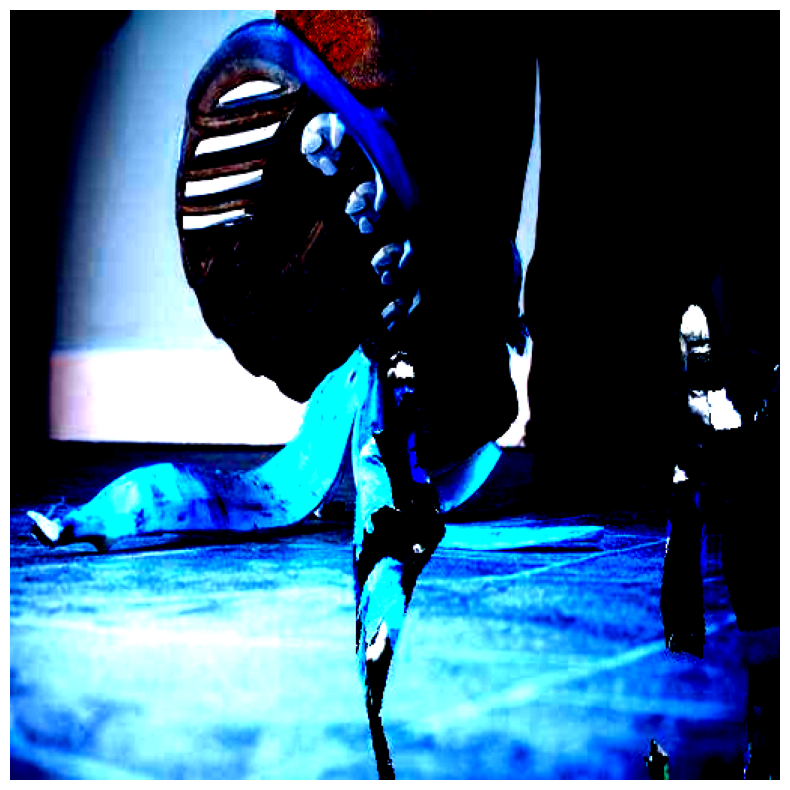

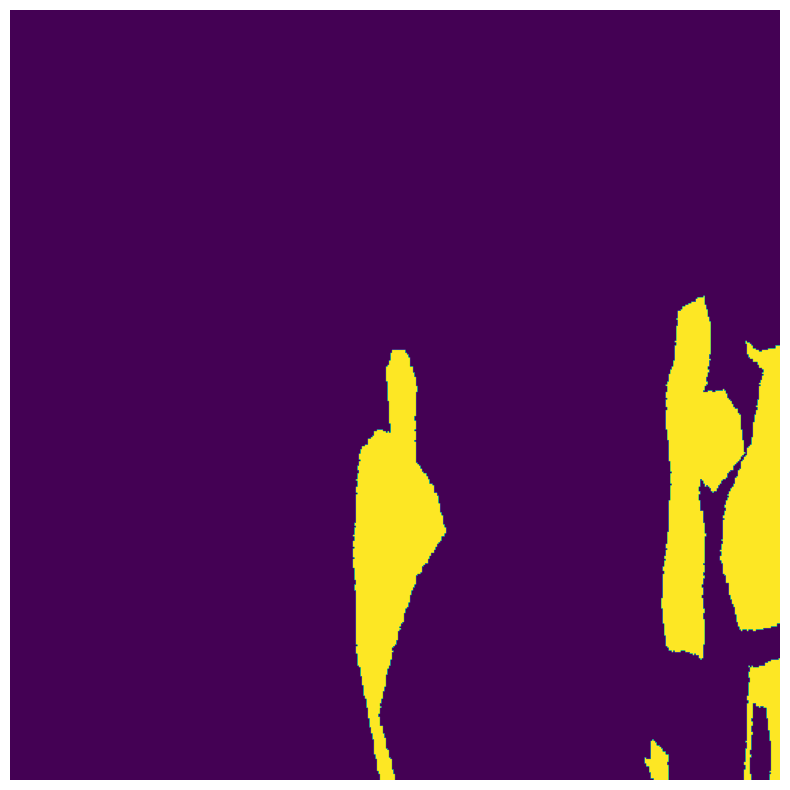

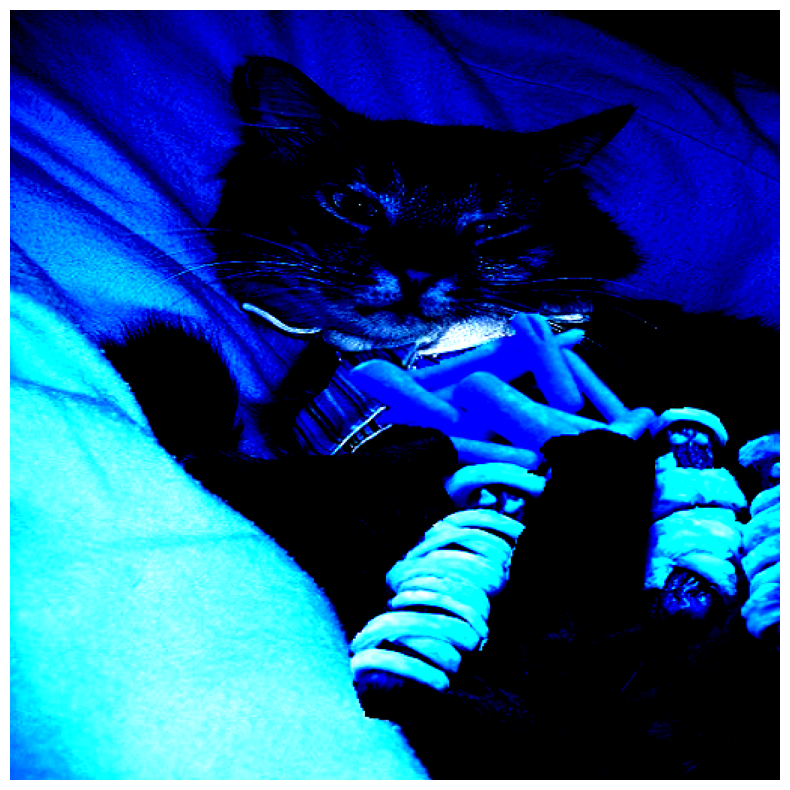

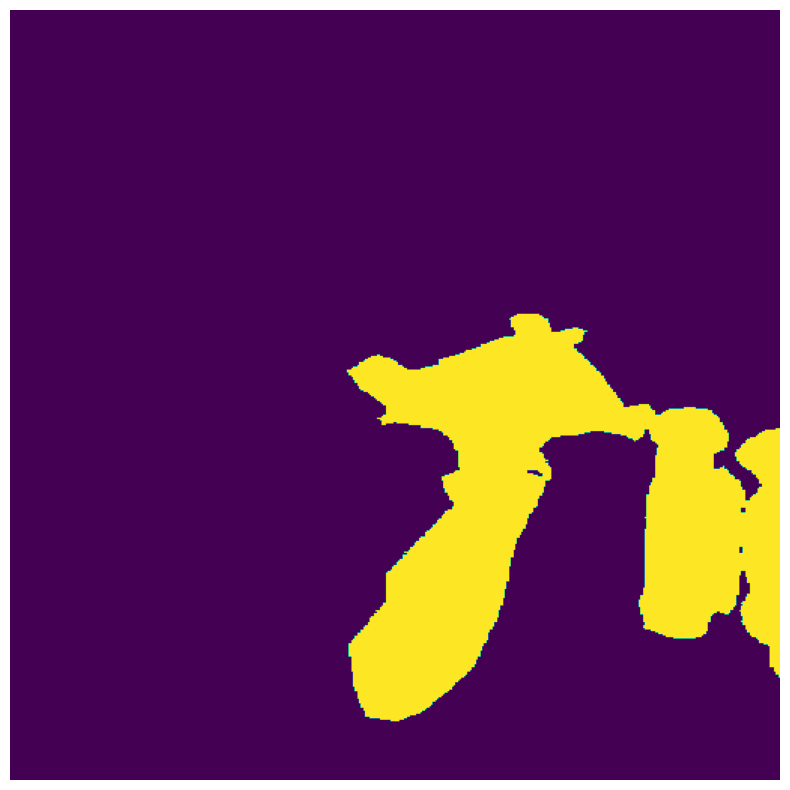

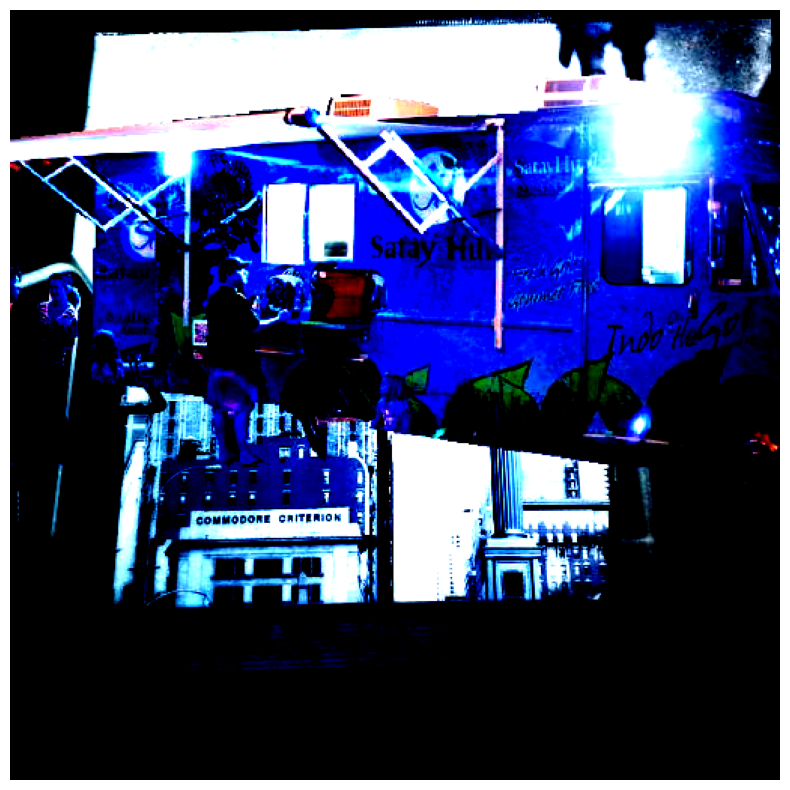

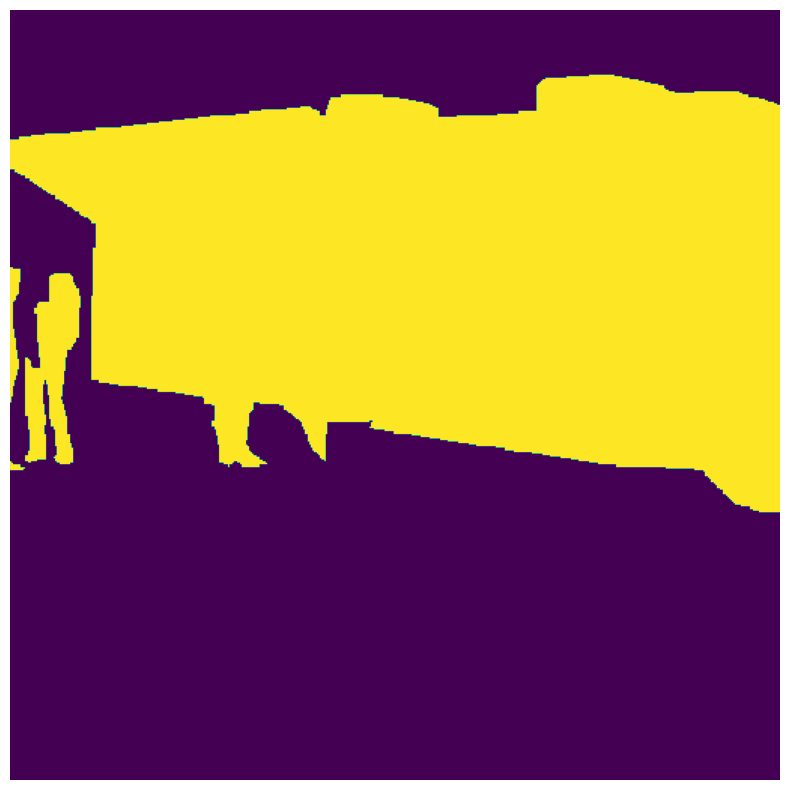

In [29]:
for i in range(3):
    display_image(validation_ds[i]["pixel_values"])
    display_image(validation_ds[i]["labels"])

In [30]:
train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=True)
validation_dataloader = DataLoader(validation_ds, batch_size=2)

In [31]:
for batch in train_dataloader:
    break

In [32]:
batch["pixel_values"].shape

torch.Size([2, 3, 512, 512])

In [33]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [34]:
id2label = {
    1: "tampered",
}

In [35]:
label2id={
    v: k
    for k, v in id2label.items()
}

In [36]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=1,
    id2label=id2label,
    label2id=label2id,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [182]:
metrics = evaluate.load("mean_iou")

In [183]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cuda')

In [21]:
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [187]:
model.train()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [188]:
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)
trainable_params

3714401

In [189]:
accumulate_steps = 60

model.train()
min_val_loss = 0.0
i_val = 0
for epoch in range(11): 
    print("Epoch: ", epoch)
    losses = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss = loss / accumulate_steps

        loss.backward()

        if (idx + 1) % accumulate_steps == 0 or (idx + 1) == len(train_dataloader):

            add_batch = True
            
            optimizer.step()
            
            optimizer.zero_grad()

        else:
            add_batch = False

        if add_batch:

            with torch.no_grad():

                losses.append(loss.item() * accumulate_steps)

                unsampled_logits = torch.nn.functional.interpolate(
                    logits,
                    size=labels.shape[-2:], 
                    mode="bilinear",
                    align_corners=False,
                )

                predicted = torch.sigmoid(unsampled_logits) 
                predicted = torch.where(predicted > 0.5, 1, 0)

                metrics.add_batch(
                    predictions=predicted.detach().cpu().squeeze(1).numpy(),
                    references=labels.detach().cpu().numpy(),    
                )

    metrics_train = metrics._compute(
        predictions=predicted.detach().cpu().squeeze(1).numpy(),
        references=labels.detach().cpu().numpy(),    
        num_labels=len(id2label),
        ignore_index=255,
        reduce_labels=False,
    )

    print("... Train metrics")
    print("Loss: ", np.mean(losses))
    print("Mean Accuracy: ", metrics_train["mean_accuracy"])
    print("Mean IoU: ", metrics_train["mean_iou"])
    print("\n")

    with torch.no_grad():
        model.eval()
        val_losses = []
        for val_batch in validation_dataloader:
            pixel_values = val_batch["pixel_values"].to(device)
            labels = val_batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            val_losses.append(loss.item())

            unsampled_logits = torch.nn.functional.interpolate(
                logits,
                size=labels.shape[-2:], 
                mode="bilinear",
                align_corners=False,
            )

            predicted = torch.sigmoid(unsampled_logits) 
            predicted = torch.where(predicted > 0.5, 1, 0)

            metrics.add_batch(
                predictions=predicted.detach().cpu().squeeze(1).numpy(),
                references=labels.detach().cpu().numpy(),    
            )

        metrics_val = metrics._compute(
            predictions=predicted.detach().cpu().squeeze(1).numpy(),
            references=labels.detach().cpu().numpy(), 
            num_labels=len(id2label),
            ignore_index=255,
            reduce_labels=False,
        )

        model.train()
    
    val_loss = np.mean(val_losses)
    if i_val == 0:
        min_val_loss = val_loss
        torch.save(model.state_dict(), "segformer_cm_checkpoint")
    else:
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), "segformer_cm_checkpoint")
            
    print("... Validation metrics")
    print("Loss: ", val_loss)
    print("Mean Accuracy: ", metrics_val["mean_accuracy"])
    print("Mean IoU: ", metrics_val["mean_iou"])
    print("\n")

    i_val += 1

Epoch:  0


98717it [4:02:08,  6.79it/s]


... Train metrics
Loss:  0.1589731281270462
Mean Accuracy:  0.9982782207629769
Mean IoU:  0.992791171371485


... Validation metrics
Loss:  0.058397253357501094
Mean Accuracy:  0.9938628848914719
Mean IoU:  0.98276742661578


Epoch:  1


98717it [4:06:45,  6.67it/s]


... Train metrics
Loss:  0.07320158103547983
Mean Accuracy:  0.9948249999010517
Mean IoU:  0.9874442879563772


... Validation metrics
Loss:  0.05253363923470159
Mean Accuracy:  0.9975150580972096
Mean IoU:  0.9761912342986324


Epoch:  2


98717it [4:05:08,  6.71it/s]


... Train metrics
Loss:  0.05906238550728923
Mean Accuracy:  0.9816442536044409
Mean IoU:  0.965991717086479


... Validation metrics
Loss:  0.08174611808907592
Mean Accuracy:  0.9956035643258324
Mean IoU:  0.9557907724023224


Epoch:  3


98717it [4:04:39,  6.72it/s]


... Train metrics
Loss:  0.054009691920220704
Mean Accuracy:  0.991501318612069
Mean IoU:  0.970356712140125


... Validation metrics
Loss:  0.11765795603967487
Mean Accuracy:  0.9997559795185476
Mean IoU:  0.948537185809429


Epoch:  4


98717it [4:04:39,  6.72it/s]


... Train metrics
Loss:  0.05084395010265061
Mean Accuracy:  0.9969027938469368
Mean IoU:  0.9876260194304779


... Validation metrics
Loss:  0.13516299467569287
Mean Accuracy:  1.0
Mean IoU:  0.9439534705159706


Epoch:  5


30839it [1:16:40,  6.70it/s]


KeyboardInterrupt: 

In [190]:
with torch.no_grad():
    model.eval()
    val_losses = []
    for val_batch in validation_dataloader:
        pixel_values = val_batch["pixel_values"].to(device)
        labels = val_batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        val_losses.append(loss.item())

        unsampled_logits = torch.nn.functional.interpolate(
                logits,
                size=labels.shape[-2:], 
                mode="bilinear",
                align_corners=False,
            )

        predicted = torch.sigmoid(unsampled_logits) 
        predicted = torch.where(predicted > 0.5, 1, 0)

        metrics.add_batch(
                predictions=predicted.detach().cpu().squeeze(1).numpy(),
                references=labels.detach().cpu().numpy(),    
            )

    metrics_val = metrics._compute(
            predictions=predicted.detach().cpu().squeeze(1).numpy(),
            references=labels.detach().cpu().numpy(), 
            num_labels=len(id2label),
            ignore_index=255,
            reduce_labels=False,
        )

In [191]:
metrics_val["mean_iou"], metrics_val["mean_accuracy"]

(0.9379615783691406, 1.0)

In [34]:
model.load_state_dict(torch.load("segformer_cm"))

<All keys matched successfully>

In [192]:
torch.save(model.state_dict(), "segformer_cm")